### VGG网络搭建
在基础的CNN网络结构中，卷积层、池化层以及全连接层之间是串行结构，网络的结构相对简单，在面对更复杂的问题时泛化能力不足。
<img src="./Image/basic_cnn.jpg" alt="基础CNN网络" width="70%">
    
    
VGG网络引入了更深层次的卷积神经网络结构，将包含多个不同大小、不同数量的卷积层使用并行的结构分别提取特征，使用concatenate将特征进行汇聚，封装为Inception层再进行连接，从而能够学习到更加复杂的图像特征。
<img src="./Image/VGG_network.jpg" alt="VGG网络结构" width="70%">

以下是Inception模块的基本结构。
<img src="./Image/Inception.jpg" alt="Inception模块" width="50%">
关于1x1卷积核的作用，考虑以下场景。
我们要将192x28x28的数据，处理成32x28x28的数据
1. 若使用5x5的卷积核，一共要进行5x5x28x28x192x32=120,422,400次浮点运算（padding=1）。
2. 若使用1x1的卷积核，考虑以下路径192x28x28->16x28x28->32x28x28，则一共进行1x1x28x28x192x16+1x1x28x28x16x32=12,433,648次运算。
使用1x1的卷积核可以降低浮点数计算的次数，同时ba

In [1]:
# 接下来开始构建Inception模块
# 先引入必要的包
import torch.nn as nn
import torch
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
import torch.optim as optim
import os
import gzip
import numpy as np

In [2]:
class InceptionA(nn.Module):
    def __init__(self, in_channels):
        super(InceptionA,self).__init__()
        # 构建卷积层
        self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        # 为了保证不同分支连接时，图片的尺寸大小一致，在进行3x3卷积操作时需要设置padding=1保证输出图片的大小与原图片一致
        # 同理，进行5x5卷积操作时也需要设置padding=2
        self.branch3x3_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3x3_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)
        
        self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)
        
        self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)
        
    
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)
        
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
        
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        
        outputs = [branch1x1, branch5x5, branch3x3, branch_pool]
        # 在pytorch当中，输入数据的格式一般为batch×channel×width×height
        # dim=1意味着在第二个维度上进行拼接，也就是在channel维度上进行拼接，形成一个新的输入通道的批数据
        return torch.cat(outputs, dim=1)

In [3]:
# 构建VGG网络
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(88, 20, kernel_size=5)
        
        self.incep1 = InceptionA(in_channels=10)
        self.incep2 = InceptionA(in_channels=20)
        
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(1408, 10)
        
        
    def forward(self, x):
        in_size = x.size(0)
#         print(in_size)
        x = F.relu(self.mp(self.conv1(x)))
        x = self.incep1(x)
        x = F.relu(self.mp(self.conv2(x)))
        x = self.incep2(x)
        
        x = x.view(in_size,-1)
        x = self.fc(x)
        return x

In [4]:
# 构建数据集
class MNISTDataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.train = train
        self.transform = transform

        if self.train:
            images_file = 'train-images-idx3-ubyte.gz'
            labels_file = 'train-labels-idx1-ubyte.gz'
        else:
            images_file = 't10k-images-idx3-ubyte.gz'
            labels_file = 't10k-labels-idx1-ubyte.gz'

        self.images_path = os.path.join(root, images_file)
        self.labels_path = os.path.join(root, labels_file)

        self.images, self.labels = self.load_data()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = int(self.labels[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

    def load_data(self):
        with gzip.open(self.images_path, 'rb') as f_images:
            images = np.frombuffer(f_images.read(), dtype=np.uint8, offset=16).reshape(-1, 28, 28)

        with gzip.open(self.labels_path, 'rb') as f_labels:
            labels = np.frombuffer(f_labels.read(), dtype=np.uint8, offset=8)

        return images, labels

In [5]:
batch_size = 64
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.1307, ), (0.3081, ))
])

In [6]:
train_dataset = MNISTDataset(root='./mnist_dataset/', train=True, transform=transform)
train_loader =  DataLoader(train_dataset,shuffle=True,batch_size=batch_size)

test_dataset = MNISTDataset(root='./mnist_dataset/', train=False, transform=transform)
test_loader =  DataLoader(test_dataset,shuffle=False,batch_size=batch_size)
print(test_dataset.__len__())
print(train_dataset.__len__())

10000
60000


In [7]:
model = VGGNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

VGGNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(88, 20, kernel_size=(5, 5), stride=(1, 1))
  (incep1): InceptionA(
    (branch1x1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch3x3_1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch3x3_2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch3x3_3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch5x5_1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (branch_pool): Conv2d(10, 24, kernel_size=(1, 1), stride=(1, 1))
  )
  (incep2): InceptionA(
    (branch1x1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch3x3_1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch3x3_2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch3x3_3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), 

In [8]:
# construct loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [9]:
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader,0):
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs,target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if batch_idx%300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 300))
            running_loss = 0.0

In [10]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('accuracy on test set: %d %% ' % (100*correct/total))
    return correct/total

D:\application\Anaconda\envs\pytorch-gpu\lib\site-packages\torchvision\transforms\functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


[1,   300] loss: 0.918
[1,   600] loss: 0.195
[1,   900] loss: 0.144
accuracy on test set: 97 % 
[2,   300] loss: 0.112
[2,   600] loss: 0.096
[2,   900] loss: 0.081
accuracy on test set: 97 % 
[3,   300] loss: 0.079
[3,   600] loss: 0.073
[3,   900] loss: 0.071
accuracy on test set: 98 % 
[4,   300] loss: 0.065
[4,   600] loss: 0.062
[4,   900] loss: 0.063
accuracy on test set: 98 % 
[5,   300] loss: 0.058
[5,   600] loss: 0.057
[5,   900] loss: 0.052
accuracy on test set: 98 % 
[6,   300] loss: 0.047
[6,   600] loss: 0.051
[6,   900] loss: 0.049
accuracy on test set: 98 % 
[7,   300] loss: 0.044
[7,   600] loss: 0.046
[7,   900] loss: 0.044
accuracy on test set: 98 % 
[8,   300] loss: 0.042
[8,   600] loss: 0.041
[8,   900] loss: 0.040
accuracy on test set: 98 % 
[9,   300] loss: 0.034
[9,   600] loss: 0.041
[9,   900] loss: 0.039
accuracy on test set: 98 % 
[10,   300] loss: 0.035
[10,   600] loss: 0.035
[10,   900] loss: 0.036
accuracy on test set: 98 % 


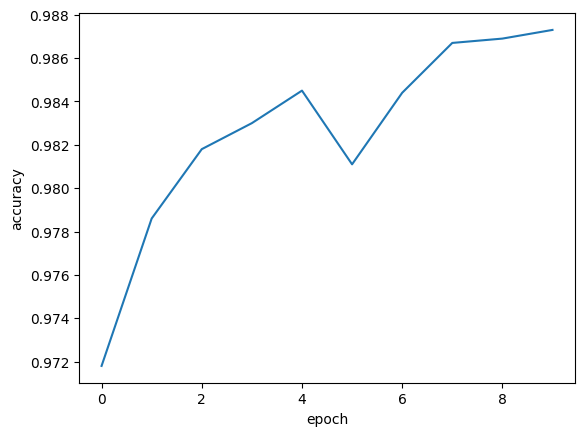

In [11]:
import matplotlib.pyplot as plt

if __name__ == '__main__':
    epoch_list = []
    acc_list = []
    
    for epoch in range(10):
        train(epoch)
        acc = test()
        epoch_list.append(epoch)
        acc_list.append(acc)
    
    plt.plot(epoch_list,acc_list)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()